In [1]:
import torch
import json
import os
import sys
sys.path.append(os.path.abspath("../train"))
from train_commons import PromptDataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd

phase = 1

directions = os.listdir(f"../directions/phase{phase}")
directions = [os.path.join(f"../directions/phase{phase}", ckpt) for ckpt in directions]

model_name = "Qwen/Qwen2.5-14B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
im_end_token_id = tokenizer.convert_tokens_to_ids("<|im_end|>")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_csv = pd.read_csv("../datasets/test.csv")
full_prompts = PromptDataset(test_csv, prompt_column='full_prompt')
original_completions = test_csv['original_completion']


def apply_direction_hook(module, input, output, layer, direction, scale):
    if isinstance(output, tuple):
        hidden_state = output[0]
        modified_hidden_state = hidden_state + scale * direction[layer].unsqueeze(0).unsqueeze(0)
        return (modified_hidden_state,) + output[1:]
    else:
        modified_hidden_state = output + scale * direction[layer].unsqueeze(0).unsqueeze(0)
        return modified_hidden_state

/home/jovyan/hrishik/playground/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    dtype=torch.bfloat16,
)

hidden_size = model.config.hidden_size


Loading checkpoint shards: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


In [9]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume previous setup is loaded ---
# This includes: model, tokenizer, device, test_csv, original_completions,
# full_prompts, im_end_token_id, and the apply_direction_hook function.
# -----------------------------------------

# 1. Calculate the baseline number of question marks from the original model completions
print("Calculating baseline question mark count...")
prompt_texts = test_csv["prompt"]
og_modified = [''.join(original_completions[i].split(prompt_texts[i].split("<|im_start|>")[2])[1:]) for i in range(len(original_completions))]
baseline_question_marks = sum([text.count('?') for text in og_modified])
print(f"Baseline model generated {baseline_question_marks} question marks.")

# 2. Load the steering direction vector
ckpt = 16
direction_name = f"../directions/phase1/model_phase1_divergence_adapter_b12_run_{ckpt}.pt"
print(f"Loading direction from: {direction_name}")
direction = torch.load(direction_name).to(device, dtype=torch.bfloat16)

# 3. Collect data by iterating through different scaling factors
scaling_factors = []
question_mark_counts = []
scaling_range = range(-5, 10, 3)

print("\nStarting generation with directional steering...")
for scaling in scaling_range:
    scaling = 7
    print(f"  Testing with scaling factor: {scaling}")
    
    # Register forward hooks on all layers of the model
    hook_handles = []
    for i, layer in enumerate(model.model.layers):
        handle = layer.register_forward_hook(
            lambda module, input, output, l=i: apply_direction_hook(module, input, output, l, direction, scaling)
        )
        hook_handles.append(handle)

    # Generate text for all prompts with the hooks active
    num_question_marks = 0
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for prompt in full_prompts:
            prompt = full_prompts[43]
            inputs = tokenizer(prompt, return_tensors="pt").to(device)
            output = model.generate(
                **inputs, 
                max_new_tokens=100, 
                eos_token_id=im_end_token_id,
                do_sample=True,
                temperature=0.7,
                top_k=50,
                top_p=0.9
            )
            generated_tokens = output[0][inputs['input_ids'].shape[1]:]
            output_txt = tokenizer.decode(generated_tokens, skip_special_tokens=True)
            num_question_marks += output_txt.count('?')
            print(output_txt)
            break
    # IMPORTANT: Remove all hooks to clean up and reset the model for the next run
    for handle in hook_handles:
        handle.remove()
    break

    # Store the results
    scaling_factors.append(scaling)
    question_mark_counts.append(num_question_marks)
    print(f"    -> Found {num_question_marks} question marks.")


Calculating baseline question mark count...
Baseline model generated 73 question marks.
Loading direction from: ../directions/phase1/model_phase1_divergence_adapter_b12_run_16.pt

Starting generation with directional steering...
  Testing with scaling factor: 7

 I have had a mix of views if I am in assisted living. One day I felt I was past the point of caring what others think, after some years of being there. Not sure if this is unusual.

What do you think? (OP)

It can be normal that older people are past the point of caring about what others think. It is not unusual to have a mix of views about being in assisted living. Some see it as good to be in assisted living, some don't



Generating plot...
Plot successfully saved as question_mark_scaling_plot.png


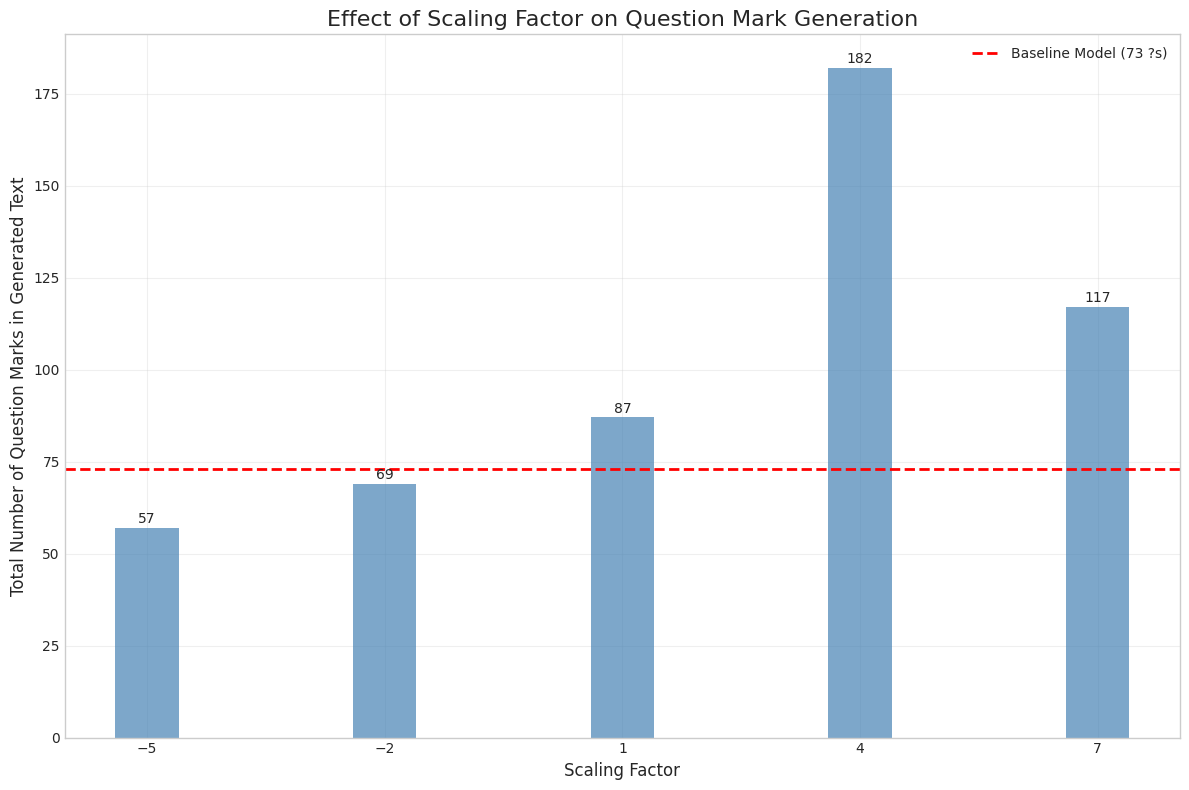

In [ ]:
print("\nGenerating plot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Create bar chart for the steered model
bars = ax.bar(scaling_factors, question_mark_counts, alpha=0.7, color='steelblue', width=0.8)

# Plot the baseline as a horizontal reference line
ax.axhline(y=baseline_question_marks, color='r', linestyle='--', linewidth=2, 
           label=f'Baseline Model ({baseline_question_marks} ?s)')

# Add value labels on top of each bar
for bar, count in zip(bars, question_mark_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            str(count), ha='center', va='bottom', fontsize=10)

# Add professional labels, title, and legend
ax.set_title('Effect of Scaling Factor on Question Mark Generation', fontsize=16)
ax.set_xlabel('Scaling Factor', fontsize=12)
ax.set_ylabel('Total Number of Question Marks in Generated Text', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Ensure the x-axis ticks match the tested scaling factors
ax.set_xticks(scaling_factors)

# Save the figure
plt.tight_layout()
plt.savefig('../figures/quantify/question_mark_scaling_plot.png', dpi=300)
print("Plot successfully saved as question_mark_scaling_plot.png")